# L1, L2 and Dropout Regularization for Financial Time-series Data

In [100]:
import random
import numpy as np
import tensorflow as tf

In [101]:
def set_seeds(seed=100):
	random.seed(seed)
	np.random.seed(seed)
	tf.random.set_seed(seed)
set_seeds()

# Prepare Data

In [102]:
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn-v0_8')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('display.precision', 4)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

import keras
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd

optimizer = keras.optimizers.Adam(learning_rate=0.001)


For this notebook we'll consider eur_usd data from October 2019 to January 2020

In [103]:
symbol = 'EUR_USD'
raw = pd.read_csv('../data/eikon_id_eur_usd.csv', index_col=0, parse_dates=True)
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96526 entries, 2019-10-01 00:00:00 to 2019-12-31 23:06:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HIGH    96526 non-null  float64
 1   LOW     96526 non-null  float64
 2   OPEN    96526 non-null  float64
 3   CLOSE   96526 non-null  float64
dtypes: float64(4)
memory usage: 3.7 MB


The dataframe above consists of OHLC 1-minute data. Next we resample the dataframe to 1 hour intervals and use only the close price.

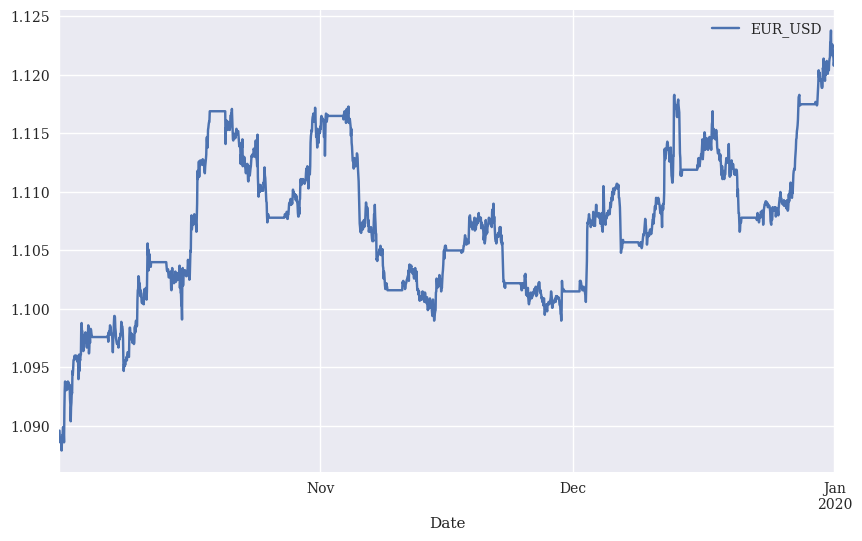

In [104]:
data = pd.DataFrame(raw['CLOSE'].loc[:])
data.columns = [symbol]
data = data.resample('1h', label='right').last().ffill()

data.plot(figsize=(10, 6));

Next we do some feature engineering, adding some lags as well as features for other financial indicators

In [105]:
lags = 5

def add_lags(data, symbol, lags, window=20):
	cols = []
	df = data.copy()
	df.dropna(inplace=True)
	df['r'] = np.log(df / df.shift())
	df['sma'] = df[symbol].rolling(window).mean()
	df['min'] = df[symbol].rolling(window).min()
	df['max'] = df[symbol].rolling(window).max()
	df['mom'] = df['r'].rolling(window).mean()
	df['vol'] = df['r'].rolling(window).std()
	df.dropna(inplace=True)
	df['d'] = np.where(df['r'] > 0, 1, 0)
	features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
	for f in features:
		for lag in range(1, lags + 1):
			col = f'{f}_lag_{lag}'
			df[col] = df[f].shift(lag)
			cols.append(col)
	df.dropna(inplace=True)
	return df, cols

data, cols = add_lags(data, symbol, lags)

In [106]:
c = data['d'].value_counts()
c

d
0    1445
1     738
Name: count, dtype: int64

# Adding a Weighting Scheme/Dealing with Class Imbalances

From the output above, we can see that the number of downward movements is much greater than the number of upwards movements. This can cause problems for training a network by biasing it to always predict downwards movements. As we can see from the EURUSD plot, despite there being a greater number of downward movements than upward movements, the net direction is still an increase. To handle this, we will use a "class weights" fuction to compensate for the imbalance during training. 

In [107]:
def cw(df):
  c0, c1 = np.bincount(df['d'])
  w0 = (1 / c0) * (len(df)) / 2
  w1 = (1 / c1) * (len(df)) / 2
  return {0: w0, 1: w1}

Using the function above, we can verify that we get an equal weighting beween the classes.

In [108]:
class_weight = cw(data)
class_weight[0] * c[0], class_weight[1] * c[1]

(1091.5, 1091.5)

# Prepare the Train/Test Split

In [109]:
split = int(len(data) * 0.8)
train, test = data.iloc[:split].copy(), data.iloc[split:].copy()

# Demonstrating the Problem (Overfitting without Regularization)

In [110]:
def create_model(hl=1, hu=128, optimizer=keras.optimizers.Adam(learning_rate=0.001)):
    model = Sequential()
    model.add(Dense(hu, input_dim=len(cols), activation='relu'))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

optimizer=keras.optimizers.Adam(learning_rate=0.001)
model = create_model(hl=1, hu=128, optimizer=optimizer)

/root/miniconda3/envs/dql/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [111]:
%%time 
hist = model.fit(train[cols], train['d'], epochs=50, verbose=False, validation_split=0.2, shuffle=False, class_weight=cw(train)) 

/root/miniconda3/envs/dql/lib/python3.10/site-packages/keras/src/trainers/data_adapters/data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


CPU times: user 8.82 s, sys: 843 ms, total: 9.66 s
Wall time: 6.71 s


In [112]:
model.evaluate(train[cols], train['d'])
model.evaluate(test[cols], test['d'])

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.5822 - loss: 0.6264


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.6260 - loss: 0.5784


[0.6137945055961609, 0.6086956262588501]

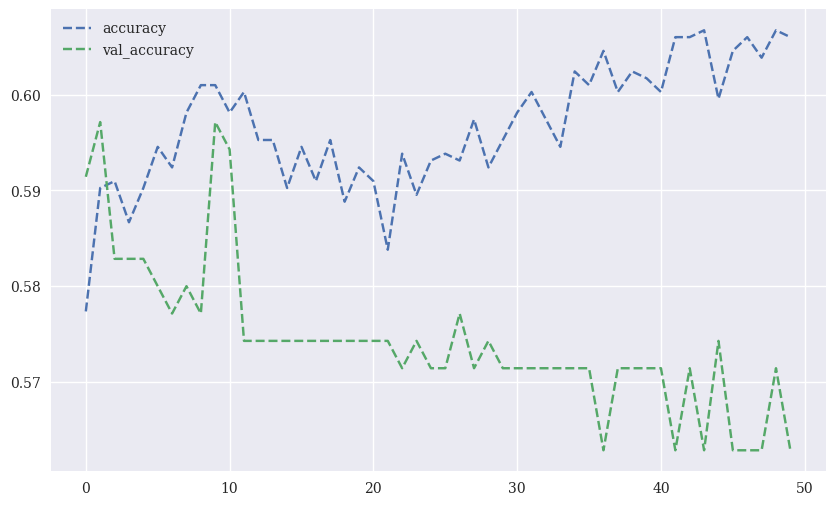

In [113]:
res = pd.DataFrame(hist.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

# Normalization

In [114]:
mu, std = train.mean(), train.std()
train_ = (train - mu) / std
test_ = (test - mu) / std

Let us train a new model using the normalized train and test data, and see how it performs.

In [115]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model = create_model(hl=2, hu=128, optimizer=optimizer)
hist = model.fit(train_[cols], train['d'], epochs=50, verbose=False,
                 validation_split=0.2, shuffle=False, class_weight=cw(train))

/root/miniconda3/envs/dql/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/root/miniconda3/envs/dql/lib/python3.10/site-packages/keras/src/trainers/data_adapters/data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


In [116]:
model.evaluate(train_[cols], train['d'])
model.evaluate(test_[cols], test['d'])

 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9688 - loss: 0.1668

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9453 - loss: 0.1787
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6601 - loss: 0.9461 


[1.004329800605774, 0.6453089118003845]

<Axes: >

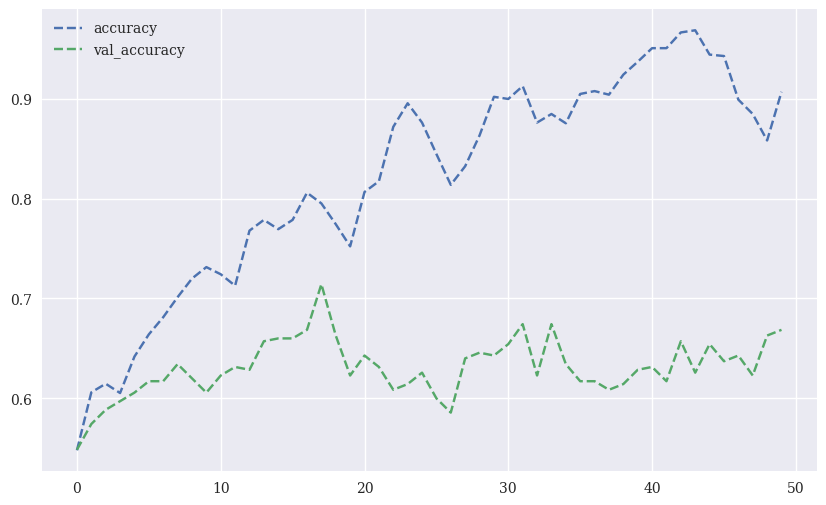

In [117]:
res = pd.DataFrame(hist.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--')

Notice that both the training accuracy and validation accuracy have improved as compared the model that was trained on unnormalized data. However, in this plot we see a large discrepancy (around (0.98-0.64)/0.64 ~ 53%) between the accuracy on the test and validation sets.

This discrepancy is indicative of overfitting. Below we will explore some strategies to remedy this difference.

# Dropout

In [118]:
from keras.layers import Dropout


def create_model(hl=1, hu=128, dropout=True, rate=0.3, optimizer=keras.optimizers.Adam(learning_rate=0.001)):
  model = Sequential()
  model.add(Dense(hu, input_dim=len(cols), activation='relu'))
  if dropout:
    model.add(Dropout(rate,seed=100))
  for _ in range(hl):
    model.add(Dense(hu, activation='relu'))
    if dropout:
      model.add(Dropout(rate, seed=100))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

model = create_model(hl=1, hu=128, rate=0.3)

/root/miniconda3/envs/dql/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [119]:
hist = model.fit(train_[cols], train['d'], epochs=50, verbose=False, validation_split=0.15, shuffle=False, class_weight=cw(train))

/root/miniconda3/envs/dql/lib/python3.10/site-packages/keras/src/trainers/data_adapters/data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


In [120]:
model.evaluate(train_[cols], train['d'])
model.evaluate(test_[cols], test['d'])

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - accuracy: 0.7832 - loss: 0.4381


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.6613 - loss: 0.5539


[0.5766004920005798, 0.6521739363670349]

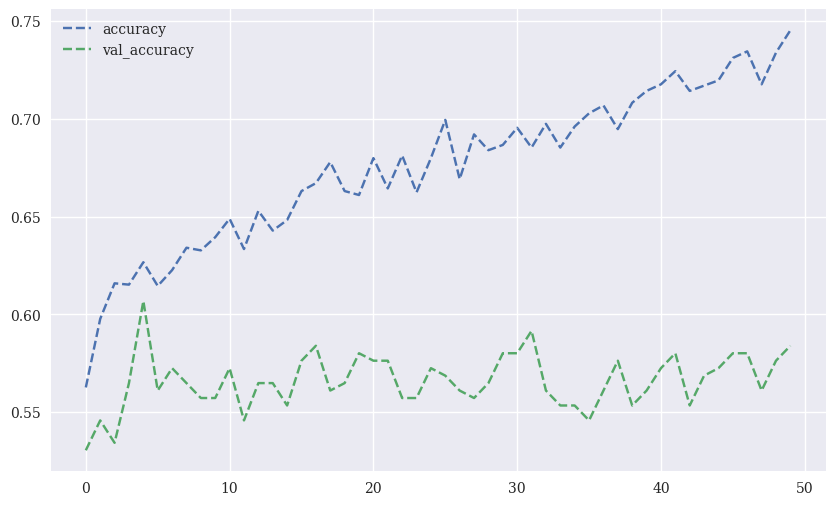

In [121]:
res = pd.DataFrame(hist.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

So applying Dropout regularization has closed the gap from around 47% to (0.75-0.55)/0.55 = 36%, a significant reduction from the 53% we had before applying Dropout regularization.

# L1 & L2 Regularization

In [122]:
from keras.regularizers import l1, l2


def create_model(hl=1, hu=128, dropout=False, rate=0.3, regularize=False, reg=l1(0.0005), optimizer=keras.optimizers.Adam(learning_rate=0.001), input_dim=len(cols)):
    if not regularize:
        reg = None
    model = Sequential()
    model.add(Dense(hu, input_dim=input_dim, activity_regularizer=reg, activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu', activity_regularizer=reg))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


model = create_model(hl=1, hu=128, regularize=True)

/root/miniconda3/envs/dql/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [123]:
%%time 
hist = model.fit(train_[cols], train['d'], epochs=50, verbose=False, validation_split=0.2, shuffle=False,  class_weight=cw(train))

/root/miniconda3/envs/dql/lib/python3.10/site-packages/keras/src/trainers/data_adapters/data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


CPU times: user 9.04 s, sys: 890 ms, total: 9.93 s
Wall time: 6.52 s


In [124]:
model.evaluate(train_[cols], train['d'])
model.evaluate(test_[cols], test['d'])

 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8750 - loss: 0.4840

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.8204 - loss: 0.4425
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6717 - loss: 0.7258 


[0.7386223077774048, 0.6521739363670349]

<Axes: >

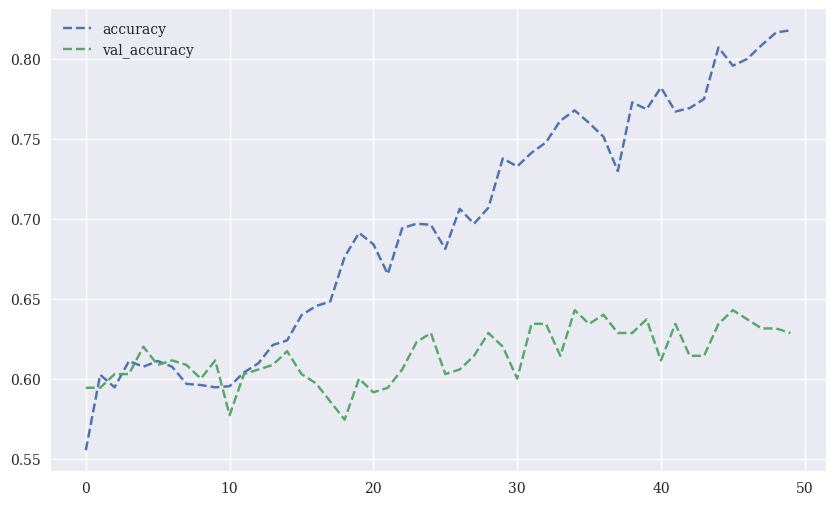

In [125]:
res = pd.DataFrame(hist.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--')

# Combining Dropout with Regularization

In [130]:
set_seeds()
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model = create_model(hl=2, hu=128, dropout=True, rate=0.3, regularize=True, reg=l2(0.001), optimizer=optimizer)

/root/miniconda3/envs/dql/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [131]:
%%time 
hist = model.fit(train_[cols], train['d'], epochs=50, verbose=False, validation_split=0.2, shuffle=False, class_weight=cw(train))

/root/miniconda3/envs/dql/lib/python3.10/site-packages/keras/src/trainers/data_adapters/data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


CPU times: user 12.6 s, sys: 1.11 s, total: 13.7 s
Wall time: 8.81 s


In [128]:
model.evaluate(train_[cols], train['d'])
model.evaluate(test_[cols], test['d'])

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3338 - loss: 2.8430 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3031 - loss: 3.0636 


[3.229177713394165, 0.3409610986709595]

<Axes: >

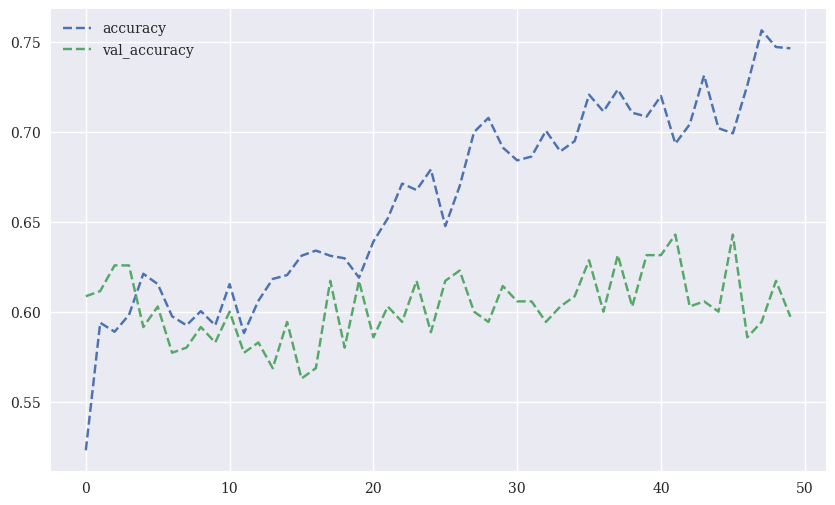

In [132]:
res = pd.DataFrame(hist.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--')

Combining both dropout and L2 regularization, we have achieved a discrepancy of (0.77-0.67)/0.67 ~ 15%, much less extreme than the 53% we found after only applying normalization.